# SVM Models — Classification de la densité urbaine  
**Auteur :** Walid El Maataoui  
**Mini-projet :** 3  

Ce notebook compare plusieurs variantes de **SVM** (linéaire, RBF, polynomial), ajoute des **visuels**, applique une **validation croisée** et réalise un **tuning** (GridSearchCV).  


In [27]:
# ============================================================
# CELL 1 — Importations + paramètres globaux
# Objectif :
#   - Importer toutes les bibliothèques nécessaires (numpy/pandas, matplotlib, scikit-learn, etc.)
#   - Définir une graine aléatoire (RANDOM_STATE) pour rendre les résultats reproductibles.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)

# Pour rendre les résultats reproductibles
RANDOM_STATE = 42


In [40]:
# ============================================================
# CELL X — Paramètres de sortie : dossier "svm_figures/" + fonctions de sauvegarde
# Objectif :
#   - Créer un nouveau dossier dédié aux résultats du SVM (sans toucher au dossier existant "figures/")
#   - Sauvegarder automatiquement :
#       * les figures (PNG) générées par matplotlib
#       * les tableaux (CSV) générés par pandas
# Utilisation :
#   - save_fig("nom.png") avant plt.show()
#   - save_table(df, "nom.csv") pour exporter un DataFrame
# ============================================================

import os
import re
import unicodedata

os.makedirs("figures", exist_ok=True)
SVM_OUT_DIR = "figures/svm_figures"
os.makedirs(SVM_OUT_DIR, exist_ok=True)

def _slugify(text: str) -> str:
    """Nettoie un texte pour en faire un nom de fichier simple et portable."""
    text = unicodedata.normalize("NFKD", str(text)).encode("ascii", "ignore").decode("ascii")
    text = text.lower().strip()
    text = re.sub(r"[^a-z0-9]+", "_", text)
    text = re.sub(r"_+", "_", text).strip("_")
    return text or "figure"

def save_fig(filename: str, dpi: int = 300):
    """Sauvegarde la figure matplotlib courante dans SVM_OUT_DIR."""
    path = os.path.join(SVM_OUT_DIR, filename)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")

def save_table(df: pd.DataFrame, filename: str, index: bool = False):
    """Sauvegarde un DataFrame pandas en CSV dans SVM_OUT_DIR."""
    path = os.path.join(SVM_OUT_DIR, filename)
    df.to_csv(path, index=index)


## 1) Chargement des données

In [29]:
# ============================================================
# CELL 2 — Chargement des données (CSV)
# Objectif :
#   - Définir le chemin vers le fichier CSV prétraité
#   - Charger le dataset dans un DataFrame pandas (df)
#   - Afficher un aperçu (df.head()) pour vérifier que tout est bien lu
# ============================================================

DATA_PATH = "data/geo_urban_density_data_preprocessed.csv"
df = pd.read_csv(DATA_PATH)
df.head()



,densite_population,densite_batiments,hauteur_moy_bat,distance_centre_km,taux_impermeabilisation,longitude,latitude,classe_urbaine,wifi_density_probe,classe_urbaine_encoded,target
0,0.453399,-0.698912,2.843182,-1.272241,-0.430125,-6.051183,34.894106,moyenne,-1.901630,1,1
1,-0.211900,0.245391,-0.813133,-0.649780,1.170118,-6.081844,34.830155,moyenne,0.001375,1,1
2,0.611582,0.682685,0.561947,-1.026238,0.140410,-6.132758,35.022266,moyenne,0.001375,1,1
3,1.528722,1.333833,0.145990,1.440636,-1.334519,-6.009676,35.016155,faible,0.001375,0,0
4,-0.312351,0.937712,0.371744,0.629681,0.189653,-5.934113,35.099108,faible,0.001375,0,0


### Aperçu rapide  
On vérifie la taille du dataset, les colonnes disponibles et la variable cible.


In [30]:
# ============================================================
# CELL 3 — Vérifications rapides du dataset
# Objectif :
#   - Vérifier la taille (shape) : nombre de lignes et de colonnes
#   - Vérifier les noms de colonnes disponibles
#   - Vérifier la répartition des classes (target) pour détecter un éventuel déséquilibre
# Utilité :
#   - Permet d’éviter les erreurs (colonne manquante, mauvais nom de target, etc.)
# ============================================================

print("Shape:", df.shape)
print("Colonnes:", list(df.columns))
print("\nRépartition des classes (target):")
print(df["classe_urbaine"].value_counts())


Shape: (1411, 11)
Colonnes: ['densite_population', 'densite_batiments', 'hauteur_moy_bat', 'distance_centre_km', 'taux_impermeabilisation', 'longitude', 'latitude', 'classe_urbaine', 'wifi_density_probe', 'classe_urbaine_encoded', 'target']

Répartition des classes (target):
classe_urbaine
faible               822
moyenne              449
zone_industrielle    114
elevee                14
industriel            12
Name: count, dtype: int64


## 2) Préparation des variables (X, y)

In [31]:
# ============================================================
# CELL 4 — Définition des variables (features X) et de la cible (y)
# Objectif :
#   - Choisir les variables explicatives (feature_cols) utilisées pour entraîner le modèle
#   - Choisir la variable cible (target_col) que le SVM doit prédire
#   - Construire X (matrice des features) et y (étiquettes/classes)
# ============================================================

# Variables explicatives (features)
feature_cols = [
    "densite_population",
    "densite_batiments",
    "hauteur_moy_bat",
    "distance_centre_km",
    "taux_impermeabilisation",
    "wifi_density_probe",
]

# Variable cible
target_col = "classe_urbaine"

# Sélection
X = df[feature_cols].copy()
y = df[target_col].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1411, 6)
y shape: (1411,)


## 3) Split Train/Test (stratifié)

In [32]:
# ============================================================
# CELL 5 — Séparation Train / Test
# Objectif :
#   - Séparer les données en un ensemble d'entraînement (train) et un ensemble de test (test)
# Paramètres clés :
#   - test_size=0.2 : 20% pour le test
#   - stratify=y : conserve la proportion des classes dans train/test 
#   - random_state : reproductibilité
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (1128, 6) (1128,)
Test : (283, 6) (283,)


## 4) Fonctions utilitaires (évaluation + visuels)

In [33]:
# ============================================================
# CELL 6 — Fonctions utilitaires (évaluation + matrice de confusion)
# Objectif :
#   - Centraliser l’affichage et le calcul des métriques pour éviter de répéter du code
# Contenu :
#   1) plot_confusion_matrix : visualisation de la matrice de confusion
#   2) evaluate_model : entraînement + prédiction + métriques (Accuracy, F1_macro, report)
# Sorties typiques :
#   - Un dictionnaire contenant le modèle entraîné, les prédictions, et un rapport détaillé.
# ============================================================

def plot_confusion_matrix(cm, class_names, title):
    """Affiche une matrice de confusion (heatmap simple avec matplotlib)."""
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    plt.colorbar(im, ax=ax)

    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    ax.set_ylabel("Vrai label")
    ax.set_xlabel("Label prédit")
    plt.tight_layout()
    # Sauvegarde automatique dans svm_figures/
    save_fig(f"{_slugify(title)}.png")
    plt.show()


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Entraîne, prédit, calcule accuracy/F1-macro + rapport + matrice."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    print(f"=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-macro  : {f1m:.4f}")

    # Rapport de classification (par classe)
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()

    # Matrice de confusion
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plot_confusion_matrix(cm, labels, f"Matrice de confusion — {model_name}")

    return {
        "Model": model_name,
        "Accuracy": acc,
        "F1_macro": f1m,
        "Report_df": report_df,
        "CM": cm,
        "Labels": labels,
        "Fitted_model": model,
        "y_pred": y_pred
    }


## 5) Modèles de base (linéaire, RBF, polynomial)

=== SVM linéaire ===
Accuracy : 0.8233
F1-macro  : 0.6210


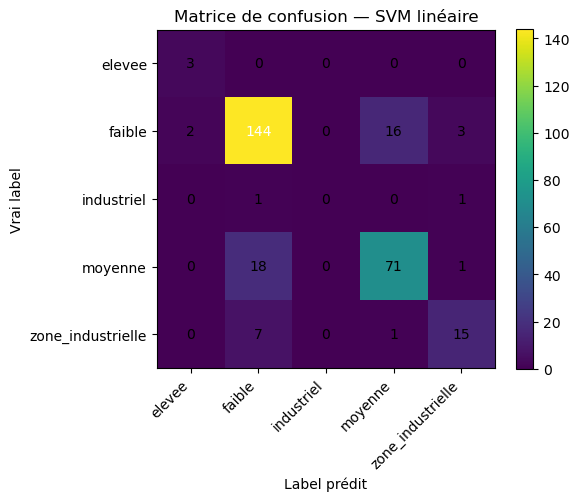

=== SVM RBF ===
Accuracy : 0.8975
F1-macro  : 0.5119


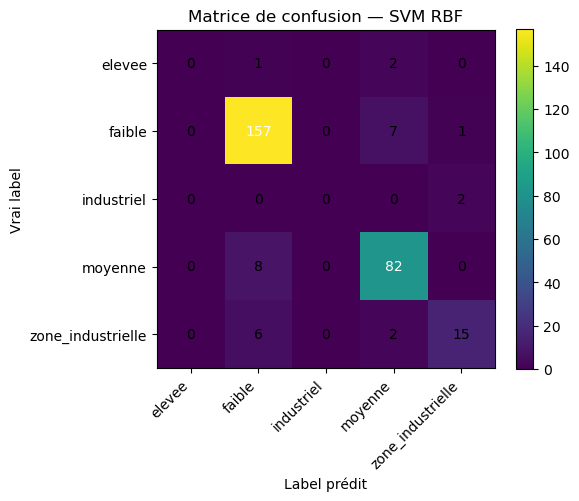

=== SVM polynomial (deg=3) ===
Accuracy : 0.8092
F1-macro  : 0.5556


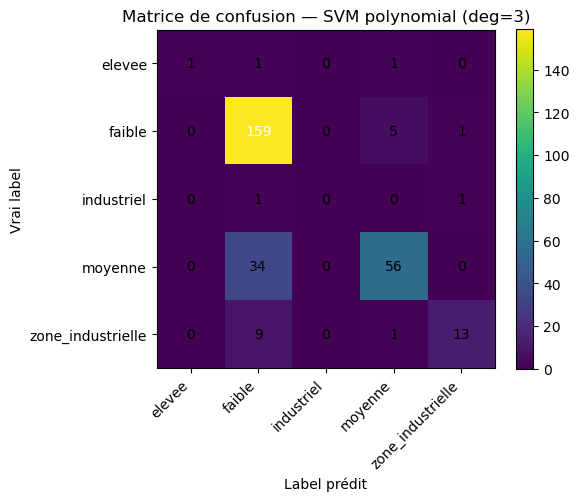

,Model,Accuracy,F1_macro
0,SVM linéaire,0.823322,0.621026
2,SVM polynomial (deg=3),0.809187,0.555605
1,SVM RBF,0.897527,0.511927


In [34]:
# ============================================================
# CELL 7 — Modèles de base (baseline) pour la comparaison
# Objectif :
#   - Construire 3 variantes de SVM (linéaire, RBF, polynomial)
#   - Utiliser un Pipeline : StandardScaler + SVC
# Pourquoi StandardScaler ?
#   - SVM est sensible à l’échelle des features : la standardisation améliore la stabilité/performance.
# Pourquoi probability=True ?
#   - Permet d’obtenir predict_proba 
# Sortie :
#   - Une liste/results_baseline qui résume les performances de chaque modèle.
# ============================================================

# Pipelines : Standardisation + SVC
svm_linear = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", random_state=RANDOM_STATE, probability=True))
])

svm_rbf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", random_state=RANDOM_STATE, probability=True))
])

svm_poly = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="poly", degree=3, random_state=RANDOM_STATE, probability=True))
])

results_baseline = []
results_baseline.append(evaluate_model(svm_linear, X_train, y_train, X_test, y_test, "SVM linéaire"))
results_baseline.append(evaluate_model(svm_rbf, X_train, y_train, X_test, y_test, "SVM RBF"))
results_baseline.append(evaluate_model(svm_poly, X_train, y_train, X_test, y_test, "SVM polynomial (deg=3)"))

summary_baseline = pd.DataFrame([
    {"Model": r["Model"], "Accuracy": r["Accuracy"], "F1_macro": r["F1_macro"]}
    for r in results_baseline
]).sort_values(by="F1_macro", ascending=False)

summary_baseline


### Comparaison visuelle (Accuracy vs F1-macro)

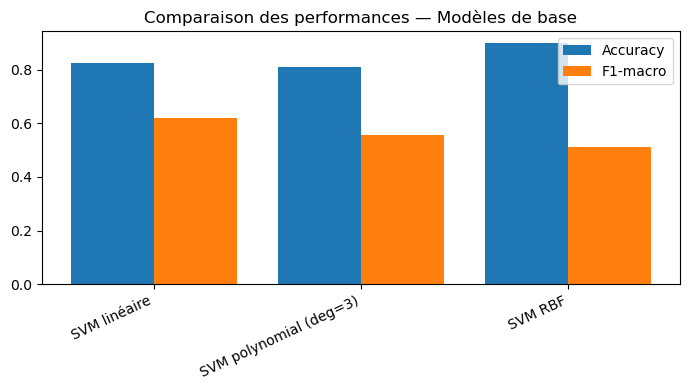

In [35]:
# ============================================================
# CELL 8 — Visualisation : comparaison des performances (baseline)
# Objectif :
#   - Créer un graphique simple (bar chart) pour comparer Accuracy et F1_macro
# Utilité :
#   - Donne une lecture rapide et visuelle des différences entre kernels SVM.
# ============================================================

fig, ax = plt.subplots(figsize=(7,4))
x = np.arange(len(summary_baseline))
ax.bar(x - 0.2, summary_baseline["Accuracy"], width=0.4, label="Accuracy")
ax.bar(x + 0.2, summary_baseline["F1_macro"], width=0.4, label="F1-macro")
ax.set_xticks(x)
ax.set_xticklabels(summary_baseline["Model"], rotation=25, ha="right")
ax.set_title("Comparaison des performances — Modèles de base")
ax.legend()
plt.tight_layout()
# Sauvegarde de la figure de comparaison dans svm_figures/
save_fig("comparaison_performances_baseline.png")
plt.show()


## 6) Validation croisée (5-fold)

In [36]:
# ============================================================
# CELL 9 — Validation croisée (Cross-Validation) pour comparer de façon robuste
# Objectif :
#   - Évaluer les modèles sur plusieurs splits (k-fold) pour réduire l’effet "chance" d’un seul split
# Contenu :
#   - StratifiedKFold : conserve les proportions de classes dans chaque fold
#   - cross_validate : calcule des scores (accuracy, f1_macro) sur chaque fold
# Sortie :
#   - cv_summary : moyenne et écart-type des métriques => comparaison plus fiable.
# ============================================================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_scores(model, X, y, name):
    scores = cross_validate(
        model, X, y, cv=cv,
        scoring={"acc":"accuracy", "f1m":"f1_macro"},
        n_jobs=-1
    )
    return {
        "Model": name,
        "CV_Accuracy_mean": scores["test_acc"].mean(),
        "CV_Accuracy_std": scores["test_acc"].std(),
        "CV_F1_macro_mean": scores["test_f1m"].mean(),
        "CV_F1_macro_std": scores["test_f1m"].std(),
    }

cv_results = []
cv_results.append(cv_scores(svm_linear, X, y, "SVM linéaire"))
cv_results.append(cv_scores(svm_rbf, X, y, "SVM RBF"))
cv_results.append(cv_scores(svm_poly, X, y, "SVM polynomial (deg=3)"))

cv_summary = pd.DataFrame(cv_results).sort_values(by="CV_F1_macro_mean", ascending=False)
cv_summary


,Model,CV_Accuracy_mean,CV_Accuracy_std,CV_F1_macro_mean,CV_F1_macro_std
0,SVM linéaire,0.829918,0.008475,0.621047,0.037501
2,SVM polynomial (deg=3),0.798709,0.017438,0.596649,0.019876
1,SVM RBF,0.897935,0.018729,0.549861,0.038984


## 8) Tuning (GridSearchCV) sur RBF

In [37]:
# ============================================================
# CELL 10 — Optimisation (tuning) du SVM RBF avec GridSearchCV
# Objectif :
#   - Trouver automatiquement les meilleurs hyperparamètres du kernel RBF
# Hyperparamètres :
#   - C : contrôle la pénalisation des erreurs (régularisation)
#   - gamma : influence la forme de la frontière de décision (plus grand => frontière plus "flexible")
#   - class_weight : None vs "balanced" pour gérer un éventuel déséquilibre des classes
# Choix du scoring :
#   - f1_macro : moyenne F1 sur les classes (utile quand on veut traiter les classes équitablement)
# Sortie :
#   - best_rbf_tuned : pipeline RBF optimisé (prêt pour l’évaluation finale sur test).
# ============================================================

# On tune RBF (C, gamma) + option class_weight
param_grid = {
    "svm__C": [0.1, 1, 10, 50],
    "svm__gamma": ["scale", 0.1, 0.01, 0.001],
    "svm__class_weight": [None, "balanced"]
}

rbf_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", random_state=RANDOM_STATE, probability=True))
])

grid = GridSearchCV(
    estimator=rbf_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Meilleurs paramètres:", grid.best_params_)
print("Meilleur score CV (F1-macro):", grid.best_score_)

best_rbf_tuned = grid.best_estimator_


Meilleurs paramètres: {'svm__C': 50, 'svm__class_weight': None, 'svm__gamma': 0.01}
Meilleur score CV (F1-macro): 0.6808271303851922


### Évaluation du meilleur modèle (tuned)

=== Meilleur RBF (tuned GridSearchCV) ===
Accuracy : 0.8799
F1-macro  : 0.6596


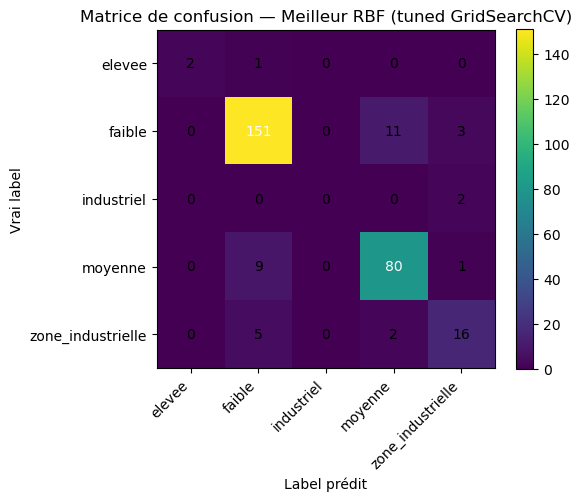

,precision,recall,f1-score,support
elevee,1.000000,0.666667,0.800000,3.000000
faible,0.909639,0.915152,0.912387,165.000000
industriel,0.000000,0.000000,0.000000,2.000000
moyenne,0.860215,0.888889,0.874317,90.000000
zone_industrielle,0.727273,0.695652,0.711111,23.000000
accuracy,0.879859,0.879859,0.879859,0.879859
macro avg,0.699425,0.633272,0.659563,283.000000
weighted avg,0.873629,0.879859,0.876282,283.000000


In [38]:
# ============================================================
# CELL 11 — Évaluation finale du meilleur modèle (sur le set de test)
# Objectif :
#   - Utiliser le meilleur modèle trouvé (GridSearch) et mesurer ses performances sur le test
# Sortie :
#   - best_report : tableau détaillé (precision, recall, f1-score) par classe + métriques globales.
# ============================================================

best_result = evaluate_model(best_rbf_tuned, X_train, y_train, X_test, y_test, "Meilleur RBF (tuned GridSearchCV)")
best_report = best_result["Report_df"]
best_report


## 10) Sauvegarde des résultats 

In [39]:
# ============================================================
# CELL 12 — Sauvegarde des résultats (CSV) dans le dossier "svm_figures/"
# Objectif :
#   - Exporter les tableaux de synthèse (baseline, validation croisée, rapport final)
#   - Tout regrouper dans un dossier dédié "svm_figures/" (sans utiliser/modifier le dossier "figures/")
# Remarque :
#   - Les fichiers CSV sont pratiques pour intégrer les résultats dans un rapport (Word/PDF) ou un README.
# ============================================================

# On réutilise SVM_OUT_DIR et la fonction save_table() définis dans la cellule "Paramètres de sortie".

save_table(summary_baseline, "summary_baseline.csv", index=False)
save_table(cv_summary, "summary_cv.csv", index=False)
save_table(best_report, "best_model_classification_report.csv", index=True)


# Résumé du travail (SVM – Classification de la densité urbaine)

Ce notebook met en place un **pipeline complet de classification supervisée** pour prédire la classe de densité urbaine (`classe_urbaine`) à partir de variables explicatives issues du jeu de données prétraité.

## Données
- **Source** : fichier CSV prétraité (`geo_urban_density_data_preprocessed.csv`).
- **Cible (target)** : `classe_urbaine`.
- **Variables (features)** : un sous-ensemble d’attributs numériques sélectionnés dans `feature_cols`.
- **Contrôle rapide** :
  - Vérification des dimensions (nombre de lignes/colonnes)
  - Inspection des colonnes disponibles
  - Distribution des classes (détection d’un éventuel déséquilibre)

## Préparation et séparation des données
- Construction de `X` (features) et `y` (target).
- **Découpage Train/Test** (ex. 80/20) avec `stratify=y` pour conserver la proportion des classes.
- Fixation d’un **RANDOM_STATE** pour assurer la reproductibilité.

## Modélisation et comparaison
- Mise en place d’un **Pipeline** `StandardScaler → SVC` afin de :
  - standardiser les variables (important pour les SVM),
  - entraîner le classifieur SVM sans fuite de données (scaling intégré au pipeline).
- **Comparaison de plusieurs noyaux (kernels)** SVM (selon la version conservée du notebook) :
  - `linear`
  - `rbf`
  - `poly`
- Les performances sont évaluées via :
  - **Accuracy**
  - **F1-score macro** (utile lorsque les classes ne sont pas parfaitement équilibrées)
  - **Classification report** (precision/recall/F1 par classe)
  - **Matrice de confusion** (visualisation des erreurs)

## Validation croisée (CV)
- Utilisation d’une **StratifiedKFold** (ex. 5 folds) pour obtenir une estimation plus robuste.
- Résumé des scores (moyenne et écart-type) pour comparer la stabilité des modèles.

## Optimisation (hyperparamètres)
- Optimisation du modèle SVM (souvent RBF) via **GridSearchCV** :
  - recherche des meilleurs `C` et `gamma` (et éventuellement `class_weight` si conservé),
  - sélection du modèle optimal selon un critère (souvent `f1_macro`).
- Évaluation finale du **meilleur modèle** sur le jeu de test.

## Sorties / Livrables
- Affichage des résultats dans le notebook (tableaux + graphiques).
- Export des résumés et rapports (si la partie sauvegarde est activée) dans le dossier `figures/` ou sous forme de CSV.


# Conclusion

## Points clés
- Le pipeline SVM est construit de manière **propre et reproductible** grâce à l’utilisation de `Pipeline` et d’un `RANDOM_STATE`.
- La **standardisation** (`StandardScaler`) est un élément critique pour obtenir de bonnes performances avec les SVM.
- La comparaison entre noyaux (kernels) et la **validation croisée** donnent une vision plus fiable que le simple score d’un seul split.
- **GridSearchCV** permet de trouver des hyperparamètres adaptés et d’améliorer significativement les performances du modèle final.

## Avantages de l’approche
- **Robustesse** : CV + métriques (Accuracy + F1 macro) + matrice de confusion.
- **Lisibilité** : pipeline et fonctions d’évaluation réutilisables.
- **Facilité de déploiement** : un pipeline entraîné peut être sauvegardé et réutilisé (optionnel selon votre besoin).

